# Intelligent App From Video Transcripts using Google Generative AI and Neo4j
In this notebook, let's explore how to leverage Google GenAI to build and consume a knowledge graph in Neo4j from Video Transcripts

This notebook parses data from [AFL after-match Commentary](https://www.afl.com.au/ondemand/shows/490977/access-all-areas?episode=13#2023) transcripts using Google Vertex AI Generative AI's `text-bison` and `code-bison` models. The models will be prompted to recognise and extract entities and relationships. We will then generate Neo4j Cypher queries using them and write the data to a Neo4j database.
We will again use `code-bison` model and prompt it to convert questions in english to Cypher - Neo4j's query language, which can be used for data retrieval.

## Setup
First off, check that the Python environment you installed in the readme is running this notebook. Make sure you select the `py38` kernel in the top right of this notebook. You should see a 3.8 version when you run this command.

In [ ]:
import sys
sys.version

Next we need to install some libraries.

In [ ]:
%pip install --user "google-cloud-aiplatform>=1.25.0" --upgrade
%pip install --user "google-cloud-aiplatform[pipelines]>=1.25.0"
%pip install --user "langchain>=0.0.216"
%pip install --user webvtt-py webvtt-to-json requests
%pip install --user graphdatascience
%pip install --user pydantic
%pip install --user IProgress
%pip install --user tqdm

**Now restart the kernel.**


That will allow the Python evironment to import the new packages.

Provide your `Project ID` (**NOT** Project Name) & `location` in the code below

![project.png](images/project.png)

![project2.png](images/project2.png)

In [ ]:
# Note, you will need to set your project_id
project_id = '<PROJECT ID HERE>'
LOCATION = 'us-central1' # SHould be us-central1 to make sure you have all features from VertexAI

In [ ]:
import vertexai
vertexai.init(project=project_id, location=LOCATION)

## Prompt Definition

In the upcoming sections, we will extract knowledge adhering to the following schema. This is a very Simplified schema to denote an AFL's Access All Areas Video Transcript. Normally, you will have Domain Experts who come up with an ideal Ontology.

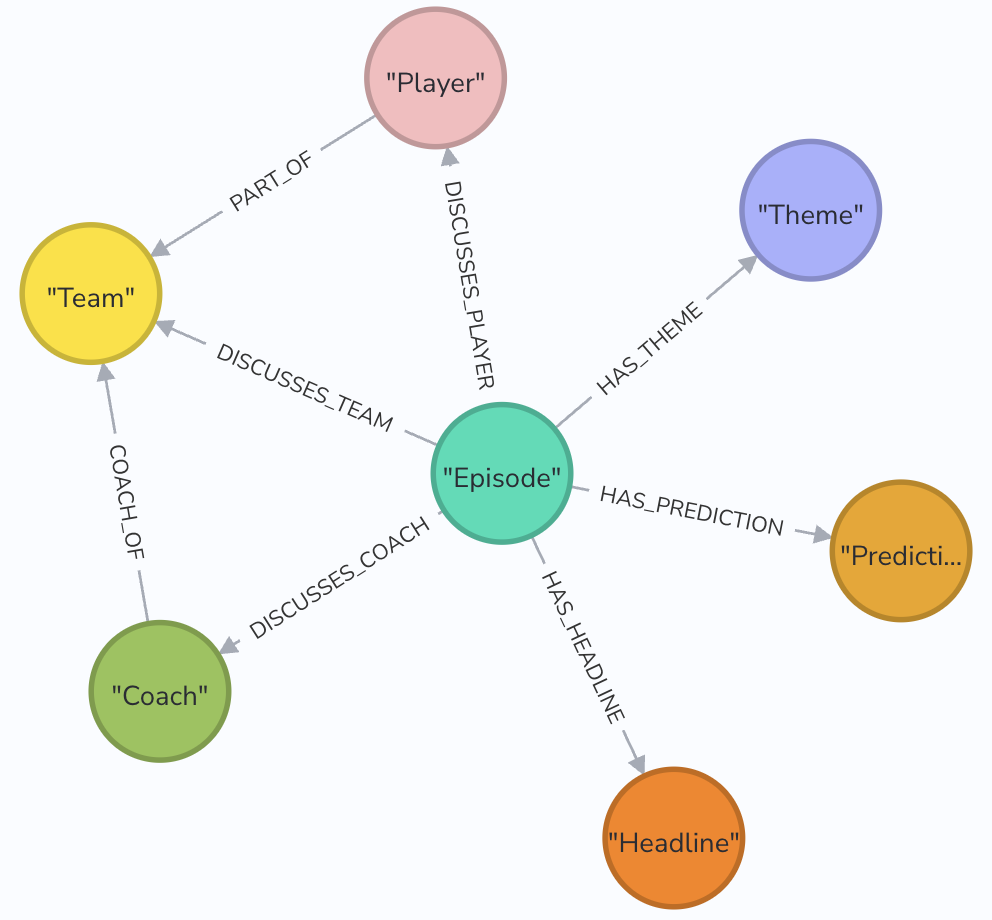

To achieve our Extraction goal as per the schema, I am going to chain a series of prompts, each focused on only one task - to extract a specific entity. By this way, you can go for more granular extraction. The prompts I used here can be improved and in production scenario, you should consider running QA on the prompt pipelines to ensure that the extracted information is correct. Also, you should consider a landing and serving zones and ensure only curated data lands the serving zone.

Our input source is `vtt` file served from a URL. So, lets write some code to extract and convert the vtt to json

In [ ]:
import webvtt
import requests
from io import StringIO
import json
from datetime import datetime

def vtt_to_json(url, dedupe, single):
    "Convert WebVTT to JSON, optionally removing duplicate lines"
    vtt_text = requests.get(url).text
    captions = webvtt.read_buffer(StringIO(vtt_text))
    dicts = []
    prev_line = None
    for c in captions:
        if any("[closed captions are auto generated]" in l for l in c.lines):
            continue
        # Collect lines that are not dupes
        not_dupe_lines = []
        for line in c.lines:
            if not line.strip():
                continue
            if line != prev_line:
                not_dupe_lines.append(line)
            prev_line = line
        if not_dupe_lines:
            start = datetime.strptime(c.start, "%H:%M:%S.%f")
            end = datetime.strptime(c.end, "%H:%M:%S.%f")
            duration = (end - start).total_seconds()
            dicts.append({"start": start, "end": end, "duration": str(duration), "lines": " ".join(not_dupe_lines)})
    return dicts


Let's text out the extraction for a `vtt` file

In [ ]:
episode_url = 'https://afl-cc-001-uptls.akamaized.net/afl_6322576158112_20230315T003159Z/afl_6322576158112_20230315T003159Z.vtt'
transcript = vtt_to_json(episode_url, True, False)
whole_transcript = ''
for t in transcript:
    whole_transcript = whole_transcript + ' ' + t['lines']
whole_transcript = whole_transcript.strip()

Now, let's write some helper functions to call VertexAI's `text-bison` and `code-bison` models. For certain extraction jobs, we will use the text model as the performance is good. FOr others, we will stick with the code model

In [ ]:
from vertexai.preview.language_models import TextGenerationModel

def run_text_model(
    project_id: str,
    model_name: str,
    temperature: float,
    max_decode_steps: int,
    top_p: float,
    top_k: int,
    prompt: str,
    location: str = LOCATION,
    tuned_model_name: str = "",
    ) :
    """Text Completion Use a Large Language Model."""
    vertexai.init(project=project_id, location=LOCATION)
    model = TextGenerationModel.from_pretrained(model_name)
    if tuned_model_name:
        model = model.get_tuned_model(tuned_model_name)
    response = model.predict(
        prompt,
        temperature=temperature,
        max_output_tokens=max_decode_steps,
        top_k=top_k,
        top_p=top_p,)
    return response.text

def prompt_text_bison(prompt, tuned_model_name=''):
    try:
        res = run_text_model(project_id, "text-bison@001", 0, 1024, 0.8, 40, prompt, LOCATION, tuned_model_name)
        return res
    except Exception as e:
        print(e)

In [ ]:
from google.cloud import aiplatform
from google.cloud.aiplatform.gapic.schema import predict
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value

def generate_code(
    api_endpoint: str,
    endpoint: str,
    input: str,
    parameters: str,
    location: str = LOCATION,
):
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.PredictionServiceClient(
      client_options=client_options
    )
    instance_dict = input
    instance = json_format.ParseDict(instance_dict, Value())
    instances = [instance]
    parameters_dict = parameters
    parameters = json_format.ParseDict(parameters_dict, Value())
    response = client.predict(
      endpoint=endpoint, instances=instances, parameters=parameters
    )
    predictions = response.predictions
    return predictions[0]["content"]

def prompt_code_bison(prompt):
    try:
        res = generate_code(LOCATION + "-aiplatform.googleapis.com", "projects/" + project_id + "/locations/" + LOCATION + "/publishers/google/models/code-bison@001", {
                  "prefix": prompt
                }, {"temperature": 0, "maxOutputTokens": 2048}, LOCATION)
        return res
    except Exception as e:
        print(e)

Now, lets define the prompts to enable our extraction process

In [ ]:
episode_prompt_tpl="""From the Australian Football League commentary episode transcript below, extract Episode entity strictly as instructed below:
1. First, look for and extract these properties for this Episode transcript:
   `id` property of each entity must be alphanumeric and must be unique among the entities. You will be referring this property to define the relationship between entities. `synopsis` property should be a summary of the transcript.
    Episode entity:
    label:'Episode',id:string,synopsis:string //Episode Node
2. synopsis property should be a a good summary of the transcript covering all the critical highlights and MUST NOT be more than 400 characters
3. If you cannot find any information on the entities & relationships above, it is okay to return empty value. DO NOT create fictious data
4. Do NOT create duplicate entities
5. Restrict yourself to extract only Episode information. No other entity information should be focussed.
6. NEVER Impute missing values
Example Output JSON:
{"entities": [{"label":"Episode","id":"episode1","synopsis":synopsis}]}

Transcript:
$ctext
Answer:
"""

In [ ]:
headline_prompt_tpl="""1. Read through the entire transcript to understand the broad topics of discussion and key events described. Get a sense of the overall flow and narrative.
2. Identify the 3 most attention-grabbing, dramatic or emotionally resonant events, incidents or outcomes discussed in the transcript. These should be specific moments that would interest or excite most readers.
3. Craft a concise yet compelling headline for each of the 3 events such that:
4. The headline conveys the essence or newsworthiness of that particular event or key moment. Capture what would make readers stop and take notice.
5. The headline follows standard headline conventions:
No more than 2 lines of text
Ideally 6 to 8 words per line
Uses engaging, dramatic or emotional language
Focuses on the latest or most impactful element of the news story.
6. The headline is coherent and grammatically correct.› The 3 headlines are diverse and reflect different events or topics from the transcript. No repetition.
7. Present the 3 headlines in the following basic format with no additional details:
- My first headline
- My second headline
8. Aim for maximum engagement and click-throughs. Put yourself in the reader's shoes and craft the kinds of dramatic yet concise headlines that would make you want to read more. 

Transcript:
$ctext
The 3 most compelling headlines are:
"""

In [ ]:
theme_prompt_tpl = """What are the important qualitative descriptors discussed? 
* Each of them should be max two words.
* Output the descriptors as a list
AFL Video Transcript:
$ctext
The important qualitative descriptors discussed are:
- ...
- ..."""

In [ ]:
team_prompt_tpl="""From the Australian Football League commentary episode transcript below, extract Team entity strictly as instructed below:
1. Read through the ENTIRE transcript carefully, without skipping any part of it. Make sure you fully comprehend the discussion and context. Missing information is often from not understanding the full context.
2. Extract ALL mentions of AFL teams as entities, regardless of their significance in the discussion. The task specifies extracting ALL teams - so none should be left out.
3. Look for mentions of Australian Football League teams in the discussion. Teams may be referred to in various ways, e.g:
    Full name: "Adelaide Crows"
    Nickname: "the Pies" (for Collingwood)
    Pronouns: "They are a dominant force" (referring to a team mentioned previously)
    Descriptive: "the team from South Australia"
4. Frequency of mention alone does not determine if a team should be extracted or not. Mentions in passing also count - understand what was referred to, not how prominently.
5. Double check at the end that no team has been missed. Re-reading the full context can help identify missed references.
6. You may want to split the transcript into shorter chunks to analyze separately, then combine the entities from each chunk in the final output. This could minimize missing information from the volume of text.
7. Ask if you have any other questions about the task or expectations before starting another attempt. Clarify doubts beforehand, rather than re-doing work.
8. Output should be this format
- First team
- Second team

Transcript:
$ctext
Here are the teams:
"""

In [ ]:
player_prompt_tpl = """From the Australian Football League commentary episode transcript below, extract Player entity strictly as instructed below:
1. Read through the ENTIRE transcript carefully. Make sure you understand all details of what is being discussed, especially around particular matches, players and teams.  
2. Look for explicit mentions of Australian Football League player names or team names in the transcript e.g. "Mason Cox", "Collingwood Magpies" etc. These indicate entities that need to be extracted.
3. Also look for pronouns (he, they), descriptions (the key forward) or positions (the ruckman) that refer to players or teams previously mentioned. These also need to be extracted. 
4. When you find a mention of a player or team, check if you have already extracted an entity for that player/team. If yes, move on. If no, create an entity.
5. For each player entity, provide the following properties: "player": The full name of the player, "team": The name of the team that the player plays for.
6. Add the entities to the output in the order in which players are first mentioned in the transcript. This helps keep track of what has already been extracted.
7. Provide all player and teams from the transcript. Do NOT skip any.
8. Do NOT create duplicate entities. Check before creating a new entity for a player.
9. Only extract player names, team names and the team that each player plays for. Do NOT extract any other information.
10. If no players can be found, return an empty string.
11. Do NOT confuse between a Player and a Coach
12. The final output format should be STRICTLY as tuples:
(player1, team1)
(player2, team2)
13. Please go through these instructions carefully and ask any questions you may have before attempting the task again. The keys are: understand the context fully, look for different types of references to players/teams, keep track of what you have already extracted, do not skip or miss any information, do not provide any extra information and check for duplicates.
Let me know if you have any other questions! I'm happy to help clarify further. Please try again to extract all player and team entities from the provided transcript. You can do this!

Transcript:
$ctext
Tuples:
"""

In [ ]:
coach_prompt_tpl = """From the Australian Football League commentary episode transcript below, extract Coach entity strictly as instructed below:
1. Read through the ENTIRE transcript carefully. Make sure you understand all details of what is being discussed, especially around particular matches, coaches and teams.  
2. Look for explicit mentions of Australian Football League coach names or team names in the transcript e.g. "Mason Cox", "Collingwood Magpies" etc. These indicate entities that need to be extracted.
3. Also look for pronouns (he, they), descriptions that refer to coaches or teams previously mentioned. These also need to be extracted. 
4. When you find a mention of a coach or team, check if you have already extracted an entity for that coach/team. If yes, move on. If no, create an entity.
5. For each coach entity, provide the following properties: "coach": The full name of the coach, "team": The name of the team that coach coaches.
6. Add the entities to the output in the order in which coaches are first mentioned in the transcript. This helps keep track of what has already been extracted.
7. Provide all coaches and teams from the transcript. Do NOT skip any.
8. Do NOT create duplicate entities. Check before creating a new entity for a coach.
9. Only extract coach names, team names and the team that each coach coaches for. Do NOT extract any other information.
10. If no coaches can be found, return an empty string.
11. Do NOT confuse between a Player and a Coach
12. The final output format should be STRICTLY as tuples like below:
(coach1, team1)
(coach2, team2)
13. Please go through these instructions carefully and ask any questions you may have before attempting the task again. The keys are: understand the context fully, look for different types of references to coaches/teams, keep track of what you have already extracted, do not skip or miss any information, do not provide any extra information and check for duplicates.
Let me know if you have any other questions! I'm happy to help clarify further. Please try again to extract all coach and team entities from the provided transcript. You can do this!

Transcript:
$ctext
Tuples:
"""

In [ ]:
predictions_prompt_tpl = """What futuristic predictions (NOT PAST EVENTS) can you extract from this Australian Football League Transcript below
1. Output should be a list of predictions in this format without any prefixes
- prediction
- prediction
2. Double check to see if you have included any past events. If so, discard them. Thats not a prediction.
Remember to understand the context fully, consider different references to predictions/predictors, avoid skipping or missing information, eliminate duplicates, include only relevant information, and adhere to the specified format.

Transcript:
$ctext
Tuples:
"""

These are the helper functions that will enable us to run the prompts we defined above. These funcitons will also process the outputs and make them more structured

In [ ]:
import re
import numpy as np
import time

CHUNK_SIZE = 5

def get_cypher_compliant_var(_id):
    s = "_"+ re.sub(r'[\W_]', '', _id).lower() #avoid numbers appearing as firstchar; replace spaces
    return s[:20] #restrict variable size

def extract_episode(text, results):
    prompts = [episode_prompt_tpl]
    for p in prompts:
            _prompt = Template(p).substitute(ctext=text)
            _extraction = prompt_code_bison(_prompt)
            if 'Answer:\n' in _extraction:
                _extraction = _extraction.split('Answer:\n ')[1]
            if _extraction.strip() == '':
                continue
            try:
                _extraction = json.loads(_extraction.replace("\'", "'"))
            except json.JSONDecodeError:
                #Temp hack to ignore cut off by token limitation
                _extraction = _extraction[:_extraction.rfind("}")+1] + ']}'
                _extraction = json.loads(_extraction.replace("\'", "'"))
            results["entities"].extend(_extraction["entities"])
            if "relationships" in _extraction:
                results["relationships"].extend(_extraction["relationships"])
    return results

def extract_multiline_str(prompt, text, results):
    _prompt = Template(prompt).substitute(ctext=text)
    _extraction = prompt_text_bison(_prompt)
    if '- ' not in _extraction:
        print(_extraction)
        raise Exception("Check prompt")
    return _extraction

def extract_headline(text, results):
    _extraction = extract_multiline_str(headline_prompt_tpl, text, results)
    i = 0
    for h in _extraction.split('- ')[1:]:
        i += 1
        headline_id = "h_"+str(round(time.time() * 1000)+i)
        results["entities"].append({"label": "Headline", "id": headline_id, "name": h.strip()})
    return results


def extract_theme(text, results):
    _prompt = Template(theme_prompt_tpl).substitute(ctext=text)
    _extraction = prompt_code_bison(_prompt)
    if '- ' not in _extraction:
        print(_extraction)
        raise Exception("Check prompt")
    i = 0
    for h in _extraction.split('- ')[1:]:
        i += 1
        results["entities"].append({"label": "Theme", "id": get_cypher_compliant_var(h.strip()), "name": h.strip()})
    return results

def extract_team(text, results):
    _extraction = extract_multiline_str(team_prompt_tpl, text, results)
    i = 0
    team_dict = {}
    for h in _extraction.split('- ')[1:]:
        i += 1
        team_name = h.strip()
        if team_name not in team_dict:
            results["entities"].append({"label": "Team", "id": get_cypher_compliant_var(team_name), "name": team_name})
            team_dict[team_name] = True
    return results

def extract_player_team(text, results):
    player_team_set = set()
    team_dict = {}
    i = 0
    text_arr = text.split('.')
    for chunk in np.array_split(text_arr, CHUNK_SIZE):
        _prompt = Template(player_prompt_tpl).substitute(ctext=".".join(chunk))
        _extraction = prompt_text_bison(_prompt)
        for t in _extraction.split('\n'):
            tmp = t.lstrip('(').rstrip(')').split(',')
            if not t.startswith('(') or len(tmp) < 2:
                continue
            player = tmp[0].strip()
            team = tmp[1].strip()
            if not player.startswith('player') and not team.startswith(player): #sometimes player and team name gets confused
                player_team_set.add((player, team))
    for (player, team) in player_team_set:
        i += 1
        player_id = get_cypher_compliant_var(player)
        results["entities"].append({"label": "Player", "id": player_id, "name": player})
        if team != 'None':
            if team not in team_dict:
                _id = get_cypher_compliant_var(team)
                results["entities"].append({"label": "Team", "id": _id, "name": team})
                team_dict[team] = _id
            results["relationships"].append(f"{player_id}|PART_OF|{team_dict[team]}")
    return results

def extract_coach_team(text, results):
    coach_team_set = set()
    team_dict = {}
    i = 0
    text_arr = text.split('.')
    for chunk in np.array_split(text_arr, CHUNK_SIZE):
        _prompt = Template(coach_prompt_tpl).substitute(ctext=".".join(chunk))
        _extraction = prompt_text_bison(_prompt)
        for t in _extraction.split('\n'):
            tmp = t.lstrip('(').rstrip(')').split(',')
            if not t.startswith('(') or len(tmp) < 2:
                continue
            coach = tmp[0].strip()
            team = tmp[1].strip()
            if not coach.startswith('coach') and not team.startswith(coach): #sometimes coach and team name gets confused
                coach_team_set.add((coach, team))
    for (coach, team) in coach_team_set:
        i += 1
        coach_id = get_cypher_compliant_var(coach)
        results["entities"].append({"label": "Coach", "id": coach_id, "name": coach})
        if 'None' != team:
            if team not in team_dict:
                _id = get_cypher_compliant_var(team)
                results["entities"].append({"label": "Team", "id": _id, "name": team})
                team_dict[team] = _id
            results["relationships"].append(f"{coach_id}|COACH_OF|{team_dict[team]}")
    return results

def extract_predictions(text, results):
    _extraction = extract_multiline_str(predictions_prompt_tpl, text, results)
    i = 0
    pred_dict = {}
    for h in _extraction.split('- ')[1:]:
        i += 1
        pred = h.strip().lstrip('prediction:').strip()
        if pred not in pred_dict:
            results["entities"].append({"label": "Prediction", "id": 'pred'+str(round(time.time() * 1000)+i), "name": pred})
            pred_dict[pred] = True
    return results

def link_entities(results):
    episode_id = results["entities"][0]["id"]
    for e in results["entities"][1:]:
        if e['label'] == 'Headline':
            results["relationships"].append(f"{episode_id}|HAS_HEADLINE|{e['id']}")
        if e['label'] == 'Theme':
            results["relationships"].append(f"{episode_id}|HAS_THEME|{e['id']}")
        if e['label'] == 'Team':
            results["relationships"].append(f"{episode_id}|DISCUSSES_TEAM|{e['id']}")
        if e['label'] == 'Player':
            results["relationships"].append(f"{episode_id}|DISCUSSES_PLAYER|{e['id']}")
        if e['label'] == 'Coach':
            results["relationships"].append(f"{episode_id}|DISCUSSES_COACH|{e['id']}")
        if e['label'] == 'Prediction':
            results["relationships"].append(f"{episode_id}|HAS_PREDICTION|{e['id']}")
    return results

In [ ]:
def extract_entities_relationships(prompt, tuned_model_name):
    try:
        res = run_text_model(project_id, "text-bison@001", 0, 1024, 0.8, 40, prompt, LOCATION, tuned_model_name)
        return res
    except Exception as e:
        print(e)
    

Now, let's run our extraction task for the transcript we tested our vtt to json conversion function

In [ ]:
from string import Template
import json

results = {"entities": [], "relationships": []}

#Extract Episode
extract_episode(whole_transcript, results)

#Extract Headline
extract_headline(whole_transcript, results)

#Extract Theme
extract_theme(whole_transcript, results)

#Extract Team
# extract_team(whole_transcript, results)

#Extract Players & their Teams
extract_player_team(whole_transcript, results)

#Extract Coaches & their Teams
extract_coach_team(whole_transcript, results)

#Extract Predictions & Predictors
extract_predictions(whole_transcript, results)

link_entities(results)


The extracted entities & relationships will look like this

In [ ]:
results

## Data Ingestion Cypher Generation

The entities and relationships we got from the LLM have to be transformed to Cypher so we can write them into Neo4j.

In [ ]:
import re

def get_prop_str(prop_dict, _id):
    s = []
    for key, val in prop_dict.items():
      if key != 'label' and key != 'id':
         s.append(_id+"."+key+' = "'+str(val).replace('\"', '"').replace('"', '\"')+'"') 
    return ' ON CREATE SET ' + ','.join(s)

def get_cypher_compliant_var(_id):
    s = "_"+ re.sub(r'[\W_]', '', _id).lower() #avoid numbers appearing as firstchar; replace spaces
    return s[:20] #restrict variable size

def generate_cypher(file_name, in_json):
    e_map = {}
    e_stmt = []
    r_stmt = []
    e_stmt_tpl = Template("($id:$label{id:'$key'})")
    r_stmt_tpl = Template("""
      MATCH $src
      MATCH $tgt
      MERGE ($src_id)-[:$rel]->($tgt_id)
    """)
    for obj in in_json:
        for j in obj['entities']:
            props = ''
            label = j['label']
            id = ''
            if label == 'Episode':
                id = file_name
            else:
                id = j['id']
            if label in ['Episode', 'Headline', 'Theme', 'Player', 'Coach', 'Team', 'Prediction']:
                varname = get_cypher_compliant_var(j['id'])
                stmt = e_stmt_tpl.substitute(id=varname, label=label, key=id)
                e_map[varname] = stmt
                e_stmt.append('MERGE '+ stmt + get_prop_str(j, varname))

        for st in obj['relationships']:
            rels = st.split("|")
            src_id = get_cypher_compliant_var(rels[0].strip())
            rel = rels[1].strip()
            if rel in ['HAS_HEADLINE', 'HAS_THEME', 'DISCUSSES_TEAM', 'DISCUSSES_PLAYER', \
                         'PART_OF', 'DISCUSSES_COACH', 'COACH_OF', 'HAS_PREDICTION']: #we ignore other relationships
                tgt_id = get_cypher_compliant_var(rels[2].strip())
                stmt = r_stmt_tpl.substitute(src_id=src_id, tgt_id=tgt_id, src=e_map[src_id], tgt=e_map[tgt_id], rel=rel)
                r_stmt.append(stmt)

    return e_stmt, r_stmt

In [ ]:
from pathlib import Path
ent_cyp, rel_cyp = generate_cypher(Path(episode_url).stem, [results])

print(ent_cyp, rel_cyp)

## Data Ingestion

You will need a Neo4j AuraDS Pro instance.  You can deploy that on Google Cloud Marketplace [here](https://console.cloud.google.com/marketplace/product/endpoints/prod.n4gcp.neo4j.io).

With that complete, you'll need to install the Neo4j library and set up your database connection.

In [ ]:
from graphdatascience import GraphDataScience

In [ ]:
import getpass

# You will need to change these variables
connectionUrl = input("Neo4j Connection URL")
username = input("DB Username")
password = getpass.getpass("DB password")

In [ ]:
gds = GraphDataScience(
    connectionUrl,
    auth=(username, password),
    aura_ds=True)

gds.set_database("neo4j")

Before loading the data, create constraints as below

In [ ]:
gds.run_cypher('MATCH (n) DETACH DELETE n')
gds.run_cypher('CREATE CONSTRAINT unique_episode_id IF NOT EXISTS FOR (n:Episode) REQUIRE (n.id) IS UNIQUE')
gds.run_cypher('CREATE CONSTRAINT unique_headline_id IF NOT EXISTS FOR (n:Headline) REQUIRE (n.id) IS UNIQUE')
gds.run_cypher('CREATE CONSTRAINT unique_theme_id IF NOT EXISTS FOR (n:Theme) REQUIRE n.id IS UNIQUE')
gds.run_cypher('CREATE CONSTRAINT unique_team_id IF NOT EXISTS FOR (n:Team) REQUIRE n.id IS UNIQUE')
gds.run_cypher('CREATE CONSTRAINT unique_player_id IF NOT EXISTS FOR (n:Player) REQUIRE n.id IS UNIQUE')
gds.run_cypher('CREATE CONSTRAINT unique_coach_id IF NOT EXISTS FOR (n:Coach) REQUIRE n.id IS UNIQUE')
gds.run_cypher('CREATE CONSTRAINT unique_prediction_id IF NOT EXISTS FOR (n:Prediction) REQUIRE n.id IS UNIQUE')

Ingest the entities

In [ ]:
%%time
for e in ent_cyp:
    gds.run_cypher(e)

Ingest relationships now

In [ ]:
%%time
for r in rel_cyp:
    gds.run_cypher(r)

Your ingested data from the above commands might look like this:

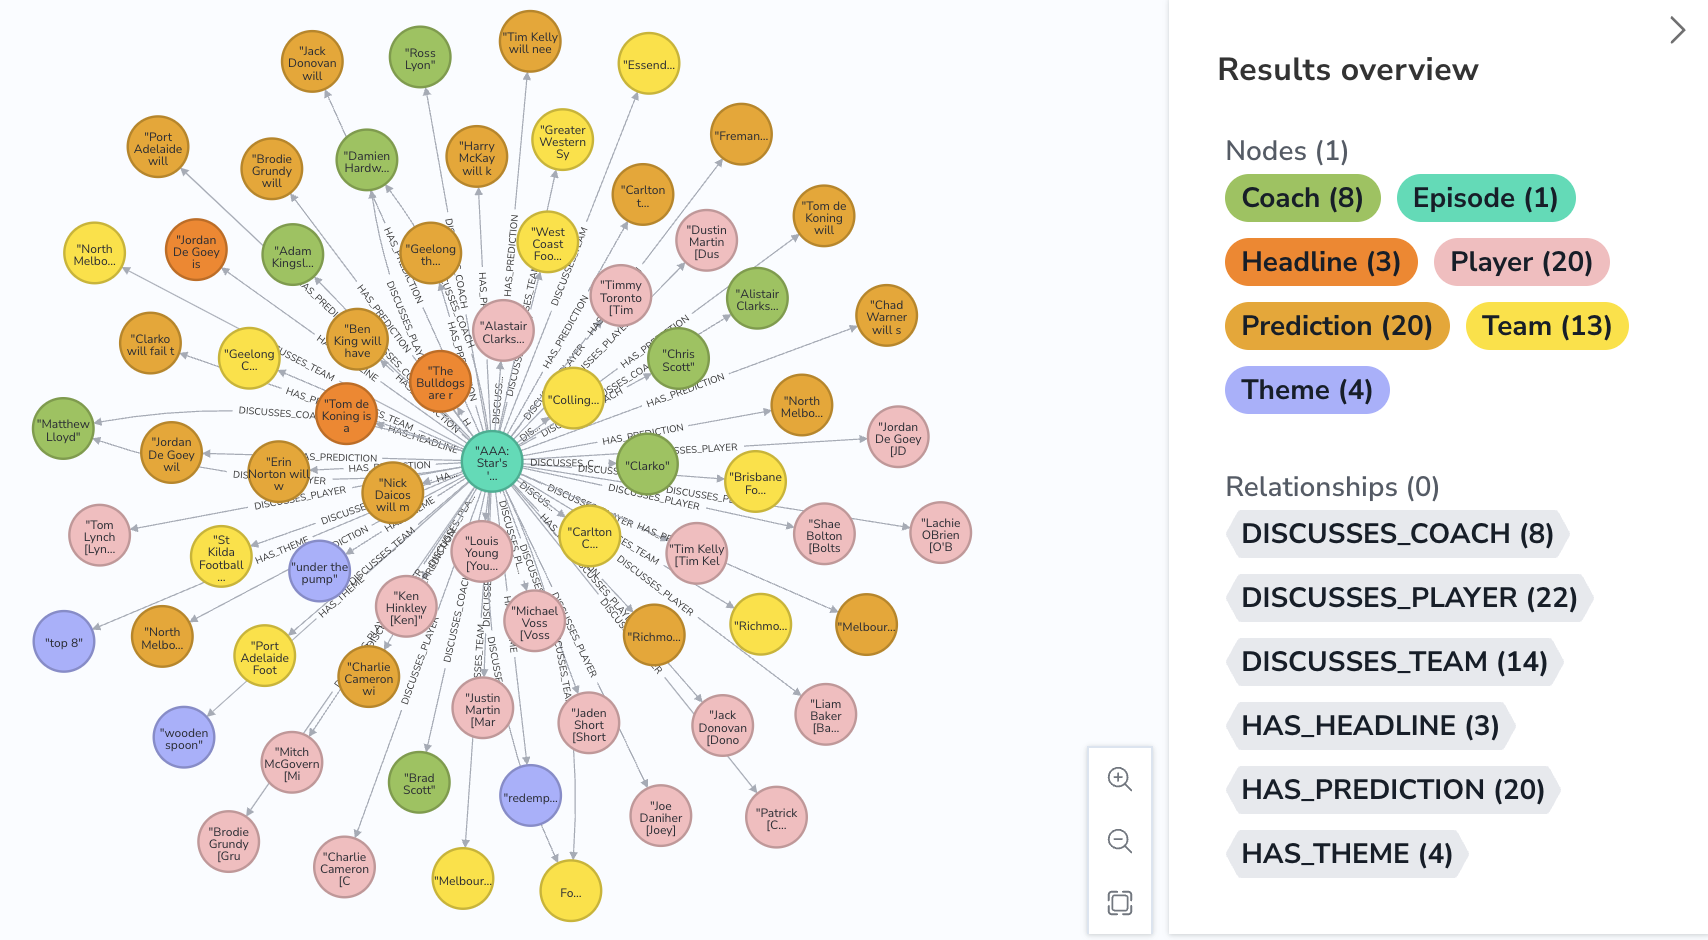

We got some video transcript URLs. Lets pipeline them and ingest to our Knowledge Graph

In [ ]:
import glob
from string import Template
import json
from pathlib import Path

def run_pipeline(transcript_urls):
    print(f"Running pipeline for {len(transcript_urls)} transcripts")
    failed_files = process_pipeline(transcript_urls)
    print(failed_files)
    return failed_files

TRUNCATE = 22000

def process_pipeline(transcript_urls):
    failed_files = []
    i = 0
    for f in transcript_urls:
        i += 1
        try:
            episode_id = Path(f).stem
            print(f"  {episode_id}: Reading Transcript No. ({i})")
            transcript = vtt_to_json(f, True, False)
            whole_transcript = ''
            for t in transcript:
                whole_transcript = whole_transcript + ' ' + t['lines']
            whole_transcript = whole_transcript.strip()
            whole_transcript = whole_transcript[:TRUNCATE]
            print(f"    {episode_id}: Extracting Entities & Relationships")
            results = run_extraction(episode_id, whole_transcript)
            print(f"    {episode_id}: Generating Cypher")
            ent_cyp, rel_cyp = generate_cypher(episode_id, results)
            print(f"    {episode_id}: Ingesting Entities")
            for e in ent_cyp:
                gds.run_cypher(e)
            print(f"    {episode_id}: Ingesting Relationships")
            for r in rel_cyp:
                gds.run_cypher(r)
            print(f"    {episode_id}: Processing DONE")
        except Exception as e:
            print(f"    {episode_id}: Processing Failed with exception {e}")
            failed_files.append(f)
    return failed_files
        
from timeit import default_timer as timer
from string import Template
import json
def run_extraction(f, whole_transcript):
    start = timer()
    results = {"entities": [], "relationships": []}

    #Extract Episode
    extract_episode(whole_transcript, results)

    #Extract Headline
    extract_headline(whole_transcript, results)

    #Extract Theme
    extract_theme(whole_transcript, results)

    #Extract Players & their Teams
    extract_player_team(whole_transcript, results)

    #Extract Coaches & their Teams
    extract_coach_team(whole_transcript, results)

    #Extract Predictions & Predictors
    extract_predictions(whole_transcript, results)

    link_entities(results)
    end = timer()
    elapsed = (end-start)
    print(f"    {f}: Entity Extraction took {elapsed}secs")
    return [results]

Lets run the pipeline now

In [ ]:
%%time
failed_files = run_pipeline(['https://afl-cc-001-uptls.akamaized.net/afl_6322933060112_20230320T002558Z/afl_6322933060112_20230320T002558Z.vtt',
'https://afl-cc-001-uptls.akamaized.net/afl_6323402071112_20230327T004117Z/afl_6323402071112_20230327T004117Z.vtt',
'https://afl-cc-001-uptls.akamaized.net/afl_6323849238112_20230403T003604Z/afl_6323849238112_20230403T003604Z.vtt',
'https://afl-cc-001-uptls.akamaized.net/afl_6324270041112_20230410T003057Z/afl_6324270041112_20230410T003057Z.vtt',
'https://afl-cc-001-uptls.akamaized.net/afl_6325230090112_20230417T001604Z/afl_6325230090112_20230417T001604Z.vtt',
'https://afl-cc-001-uptls.akamaized.net/afl_6326062468112_20230423T233555Z/afl_6326062468112_20230423T233555Z.vtt',
'https://afl-cc-001-uptls.akamaized.net/afl_6326540094112_20230501T030957Z/afl_6326540094112_20230501T030957Z.vtt',
'https://afl-cc-001-uptls.akamaized.net/afl_6327000994112_20230507T235957Z/afl_6327000994112_20230507T235957Z.vtt',
'https://afl-cc-001-uptls.akamaized.net/afl_6327488277112_20230515T000858Z/afl_6327488277112_20230515T000858Z.vtt',
'https://afl-cc-001-uptls.akamaized.net/afl_6327986707112_20230522T001659Z/afl_6327986707112_20230522T001659Z.vtt'])

If processing failed for some files due to API Rate limit, you can retry as below. For token limitation error, it is better to chunk the text and retry.

In [ ]:
%%time
while len(failed_files) > 0:
    TRUNCATE -= 500
    failed_files = process_pipeline(failed_files)

### Entity Disambiguation - Teams

After our entity extraction, some of the Team names may have some ambiguation. In this section, let us see how to disambiguate it. 

As a first step, let's first remove any special characters in the Team names. We do this, because the LLM response might miss out any special characters at times

In [ ]:
# df_teams = gds.run_cypher('MATCH (n:Team) SET n.name = trim(apoc.text.replace(n.name, "[^0-9a-zA-Z ]", "")) RETURN n.name as name')
df_teams = gds.run_cypher('MATCH (n:Team) RETURN n.name as name')
df_teams

As you see above, `Collingwood` node also has another Team node named `Collingwood Magpie`

In [ ]:
entity_disambiguation_prompt_tpl = """Here is the list of Australian Football League Teams extracted from an NLP pipeline. 
Now, disambiguate each of the Teams as tuples like (1 tuple per line):
(ambiguous_team_name, correct_official_name [correct_nick_name])
`Sydney Swans` and `Sydney Football Club` are the same team. So disambiguate them to one - `Sydney Football Club [Swans]`

Ambiguous AFL Team names list:
$ctext
Disambiguated names list:
"""

def disambiguate_teams(df_teams):
    _prompt = Template(entity_disambiguation_prompt_tpl).substitute(ctext='\n'.join(df_teams['name']))
    _extraction = prompt_text_bison(_prompt)
    for line in _extraction.split('\n'):
        tmp = line.lstrip('(').rstrip(')').split(',')
        if not line.startswith('(') or len(tmp) < 2:
            continue
        amb_name = tmp[0].strip()
        full_name = tmp[1].strip()
        print(f"{amb_name} | {full_name}")
        if len(amb_name) > 0 and amb_name != 'None':
            gds.run_cypher(f"""
                MATCH (n:Team) 
                WHERE toLower(n.name) = "{amb_name.lower()}"
                SET n.name = "{full_name}"
                RETURN n.name"""
            )

    gds.run_cypher("""MATCH (n:Team)
        WITH n.name as name, COLLECT(n) AS ns
        WHERE size(ns) > 1
        CALL apoc.refactor.mergeNodes(ns) YIELD node
        RETURN node.id, node.name""")

In [ ]:
disambiguate_teams(df_teams)
gds.run_cypher('MATCH (n:Team) RETURN n.name as name')

If you still got some teams not disambiguated correctly, look for the ambiguated and run again

In [ ]:
# df_teams = gds.run_cypher('MATCH (n:Team) SET n.name = trim(apoc.text.replace(n.name, "[^0-9a-zA-Z ]", "")) RETURN n.name as name')
df_teams = gds.run_cypher('MATCH (n:Team) WHERE NOT(n.name CONTAINS "[") RETURN n.name as name')
disambiguate_teams(df_teams)
gds.run_cypher('MATCH (n:Team) RETURN n.name as name')

### Entity Disambiguation - Players

Now lets disambiguate the Players

In [ ]:
df_players = gds.run_cypher('MATCH (n:Player)-[:PART_OF]->(t:Team) SET n.name = trim(n.name) RETURN DISTINCT n.name as player, t.name as team')
df_players

In [ ]:
player_disambiguation_prompt_tpl = """Here are the list of Australian Football League Players and their names extracted from an NLP pipeline. 
Now, disambiguate them and provide the official and nicknames for each of the Players as tuples like:
(ambiguous_player_name, official_player_name [nick_name_of_the_player])

Ambiguous AFL player & team names Format: (player, team):
$ctext
Disambiguated names:
"""
for df_split in np.array_split(df_players, 6):
    _prompt = Template(player_disambiguation_prompt_tpl).substitute(ctext='\n'.join(df_split['player']+', '+df_split['team']))
    _extraction = prompt_text_bison(_prompt)
    for line in _extraction.split('\n'):
        tmp = line.lstrip('(').rstrip(')').split(',')
        if not line.startswith('(') or len(tmp) < 2:
            continue
        amb_name = tmp[0]
        correct_name = tmp[1]
        if len(amb_name) > 0 and len(correct_name) > 0 and amb_name != 'None' and correct_name != 'None':
            gds.run_cypher(f"""
                MATCH (n:Player) 
                WHERE toLower(n.name) = "{amb_name.lower()}"
                SET n.name = "{correct_name}"
                RETURN n.name"""
            )

gds.run_cypher("""MATCH (n:Player)
WITH n.name as name, COLLECT(n) AS ns
WHERE size(ns) > 1
CALL apoc.refactor.mergeNodes(ns) YIELD node
RETURN node.id, node.name""")


In [ ]:
gds.run_cypher('MATCH (n:Player) RETURN n.name as player').head()

## Cypher Generation for Consumption

### Generate Cypher
If you are not tuning the `text-bison` model for Cypher generation, you can consider the `code-bison` model from the Codey Models family. Let us see how to use it for Cypher generation

Both Vertex AI and Neo4j support LangChain.  We will be using LangChain to quickly convert English to Cypher and then executes it on Neo4j.  This is augmented using generative AI before sending the response to the user.  This makes graph consumption easier for non-cypher experts.

The diagram below shows how Neo4j and Vertex AI will interact using LangChain.

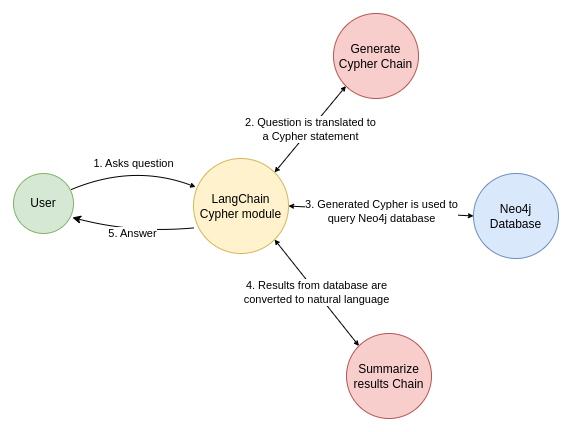

First we have to create Neo4jGraph and VertexLLM Connection objects.

In [ ]:
from langchain.chains import GraphCypherQAChain
from langchain.graphs import Neo4jGraph
from langchain.llms import VertexAI
from langchain.prompts.prompt import PromptTemplate

CYPHER_GENERATION_TEMPLATE = """You are an expert Neo4j Cypher translator who understands the question in english and convert to Cypher strictly based on the Neo4j Schema provided and following the instructions below:
1. Generate Cypher query compatible ONLY for Neo4j Version 5
2. Do not use EXISTS, SIZE keywords in the cypher. Use alias when using the WITH keyword
3. Use only Nodes and relationships mentioned in the schema
4. Always enclose the Cypher output inside 3 backticks
5. Always do a case-insensitive and fuzzy search for any properties related search. Eg: to search for a Company name use `toLower(c.name) contains 'neo4j'`
6. Candidate node is synonymous to Person
7. Always use aliases to refer the node in the query
8. Cypher is NOT SQL. So, do not mix and match the syntaxes
Schema:
{schema}
Samples:
Question: What are the predictions about Adelaide Crows?
Answer: MATCH (e:Episode)-[:HAS_PREDICTION]->(p:Prediction) WHERE toLower(p.name) CONTAINS 'adelaide crows' RETURN p.name
Question: {question}
Answer:
"""
CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"], template=CYPHER_GENERATION_TEMPLATE
)

graph = Neo4jGraph(
    url=connectionUrl, 
    username='neo4j', 
    password=password
)
chain = GraphCypherQAChain.from_llm(
    VertexAI(model_name='code-bison',
            max_output_tokens=2048,
            temperature=0,
            top_p=0.95,
            top_k=0.40), graph=graph, verbose=True,
            cypher_prompt=CYPHER_GENERATION_PROMPT,
    return_intermediate_steps=True
)

That's it! You can run the agent now. Simply provide the command in English. You get Cypher as output.

In [ ]:
r = chain("""What were predicted about Essendon and what are those episode Ids?""")

In [ ]:
print(f"Intermediate steps: {r['intermediate_steps']}")
print(f"Final answer: {r['result']}")

In [ ]:
r = chain("""What are the popular 3 themes across episodes""")

In [ ]:
print(f"Intermediate steps: {r['intermediate_steps']}")
print(f"Final answer: {r['result']}")

## Enrich Episode metadata

Let us add some metadata related to the AFL episodes like images, video URL etc. This will be useful to show them on the UI dashboard

In [ ]:
episode_metadata = {
    'afl_6322576158112_20230315T003159Z': (
        'https://www.afl.com.au/ondemand/shows/490977/access-all-areas?episode=1#2023',
        "AAA: Star's move 'not going to work', how Blues coughed it up",
        "http://bpvms-img-001-uptls.akamaized.net/web/images/20230320135738a_1024x576.jpg",
        '1'
    ),
    'afl_6322933060112_20230320T002558Z': (
        "https://www.afl.com.au/ondemand/shows/490977/access-all-areas?episode=2#2023",
        "AAA: 'Major' Buddy issue for Swans, dull Dogs are 'spooked', Cats exposed",
        "http://bpvms-img-001-uptls.akamaized.net/web/images/20230327133309a_1024x576.jpg",
        '2'
    ),
    'afl_6323402071112_20230327T004117Z': (
        "https://www.afl.com.au/ondemand/shows/490977/access-all-areas?episode=3#2023",
        "AAA: 'Sloppy' Cats a shadow of དྷ, 'scary' contender, box-office Crows",
        "http://bpvms-img-001-uptls.akamaized.net/web/images/20230403105828a_1024x576.jpg",
        '3'
    ),
    'afl_6323849238112_20230403T003604Z': (
        "https://www.afl.com.au/ondemand/shows/490977/access-all-areas?episode=4#2023",
        "AAA: AFL must step in on McCartin, how to beat the Pies, 'damning' Giants vision",
        "http://bpvms-img-001-uptls.akamaized.net/web/images/20230410101525a_1024x576.jpg",
        '4'
    ),
    'afl_6324270041112_20230410T003057Z': (
        "https://www.afl.com.au/ondemand/shows/490977/access-all-areas?episode=5#2023",
        "AAA: Dons put 'big boy pants on', big questions over Blues",
        "http://bpvms-img-001-uptls.akamaized.net/web/images/20230417102223a_1024x576.jpg",
        '5'
    ),
    'afl_6325230090112_20230417T001604Z': (
        "https://www.afl.com.au/ondemand/shows/490977/access-all-areas?episode=6#2023",
        "AAA: Trust fades in 'flawed' Blue, Crows' new polish, flag-quality Saints?",
        "http://bpvms-img-001-uptls.akamaized.net/web/images/20230424092334a_1024x576.jpg",
        '6'
    ),
    'afl_6326062468112_20230423T233555Z': (
        "https://www.afl.com.au/ondemand/shows/490977/access-all-areas?episode=7#2023",
        "AAA: Pies' miracle, how Toby broke Swans, big Tiger issues",
        "http://bpvms-img-001-uptls.akamaized.net/web/images/20230501125820a_1024x576.jpg",
        '7'
    ),
    'afl_6326540094112_20230501T030957Z': (
        "https://www.afl.com.au/ondemand/shows/490977/access-all-areas?episode=8#2023",
        "AAA: Skipper's costly error, Swans lack weapons, Daicos niggle",
        "http://bpvms-img-001-uptls.akamaized.net/web/images/20230508094606a_1024x576.jpg",
        '8'
    ),
    'afl_6327000994112_20230507T235957Z': (
        "https://www.afl.com.au/ondemand/shows/490977/access-all-areas?episode=9#2023",
        "AAA: Sloppy Saints, forgotten forwards shine, Blues blunders",
        "http://bpvms-img-001-uptls.akamaized.net/web/images/20230515095024a_1024x576.jpg",
        '9'
    ),
    'afl_6327488277112_20230515T000858Z': (
        "https://www.afl.com.au/ondemand/shows/490977/access-all-areas?episode=10#2023",
        "AAA: 'Exposed' Blues fall again, star turns into 'journeyman'",
        "http://bpvms-img-001-uptls.akamaized.net/web/images/20230522100133a_1024x576.jpg",
        '10'
    ),
    'afl_6327986707112_20230522T001659Z': (
        "https://www.afl.com.au/ondemand/shows/490977/access-all-areas?episode=11#2023",
        "AAA: Star's redemption, flopping players, recruit of the year",
        "http://bpvms-img-001-uptls.akamaized.net/web/images/20230529102516a_1024x576.jpg",
        '11'
        )
}

In [ ]:
for episode_id in episode_metadata:
    (video_url, title, img, episode) = episode_metadata[episode_id]
    gds.run_cypher(f"""
        MATCH (n:Episode)
        WHERE n.id = '{episode_id}'
        SET n.videoUrl = '{video_url}',
            n.title = "{title}",
            n.img = '{img}',
            n.episode = '{episode}'
        RETURN n
    """)

In [ ]:
gds.run_cypher("MATCH (n:Episode) return n.id, n.videoUrl, n.img, n.synopsis, n.title")